
<h2>Aim: To extract news headlines from each source, and check for outliers in case of reporters 'writers' sentiments</h2>


In [7]:
#libraries for data extraction
import os
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
from selenium.webdriver import ActionChains
import bs4
import time
import requests
import warnings
warnings.filterwarnings("ignore")

import re,string,unicodedata
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# NLP Libs
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.cluster import KMeans
from sklearn.utils.extmath import randomized_svd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Additional Libs
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet

# Download corpus
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Chetan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

<h1>Part 1: Data Extraction </h1>
done using respective .ipynb notebooks

<h1>Part 2: Processing Data into Sentiments</h1>

In [14]:
df = pd.DataFrame(columns=['headline', 'article_text', 'source','bias',	'cleaned_text',	'compound',	'positive',	'neutral','negative'])

headline = []
article_text = []
source = []
bias = []
names = ['ndtv','indianexpress','newsexp']

for j in names:
  for i in range(30): #add range here based on number of scraped articles
    try:
      with open(f'{j}/{j}_{i}.txt', 'r') as f:
        # read first line as headline
        head = f.readline()
        head = head.strip()
        headline.append(head)

        # read all other lines as the article body, join to convert list to string
        lines = f.readlines()
        lines = ''.join(lines[0::1])
        article_text.append(lines)

        #append source and bias to the list
        source.append(j)
        
        if str(j) == 'ndtv':
          bias.append('L')
        elif str(j) == 'indianexpress':
          bias.append('N')
        elif str(j) == 'newsexp':
          bias.append('R')
    except:
      continue

# add all lists to the dataframe
df["headline"] = headline
df['article_text'] = article_text
df['source'] = source
df['bias'] = bias

df_formed = df.dropna(subset = ["article_text","headline"])

df_formed.to_csv('nlpdata_trial.csv')

# function for cleaning the data, remove tweet text, ads etc.
def clean(text): 
    text = str(text)
    text = text.lower()  
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    text = re.sub(r'\s+', ' ', text)
    stops = ENGLISH_STOP_WORDS
    text = [w for w in text.split() if not w in stops]
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text]
    text = [ word for word in text if len(word) > 1 ]
    text = " ".join(text)
    return text

df_formed['cleaned_text'] = df_formed['article_text'].apply(clean)

analyzer = SentimentIntensityAnalyzer()

# use VADER for finding compound, positive, negative, neutral sentiments
def compound(doc):
   analyzer= SentimentIntensityAnalyzer()
   score_compound = analyzer.polarity_scores(doc)['compound']
   return score_compound

def pos(doc):
   analyzer= SentimentIntensityAnalyzer()
   score_pos = analyzer.polarity_scores(doc)['pos']
   return score_pos

def neu(doc):
   analyzer= SentimentIntensityAnalyzer()
   score_neu = analyzer.polarity_scores(doc)['neu']
   return score_neu

def neg(doc):
   analyzer= SentimentIntensityAnalyzer()
   score_neg = analyzer.polarity_scores(doc)['neg']

   return score_neg

# adding to the dataframe

df_formed['compound'] = df_formed['cleaned_text'].apply(compound)
df_formed['positive'] = df_formed['cleaned_text'].apply(pos)
df_formed['neutral'] = df_formed['cleaned_text'].apply(neu)
df_formed['negative'] = df_formed['cleaned_text'].apply(neg)

# deleting redundant column
try:
  df_formed.drop(['Unnamed: 0'], axis = 1)
except:
  pass  

<h1>Part 3: Anomaly Detection using Isolation Forest</h1>

<Figure size 2160x2160 with 0 Axes>

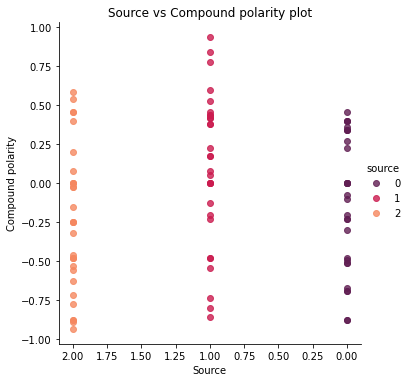

<Figure size 2160x2160 with 0 Axes>

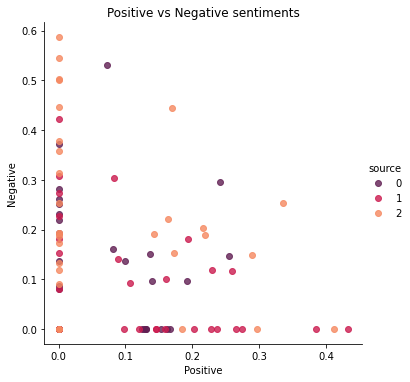


Number of anomalies in the dataset:  30


<Figure size 360x360 with 0 Axes>

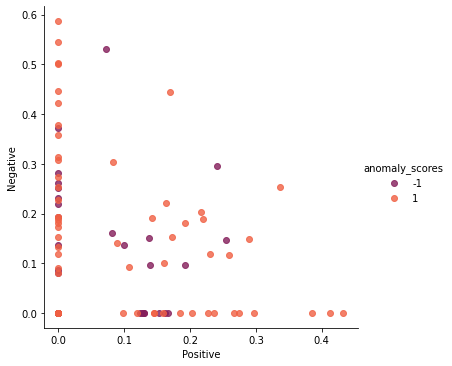

In [15]:
from sklearn.ensemble import IsolationForest


negative = df_formed[df_formed['compound']<0]

positive = df_formed[df_formed['compound']>0]

neutral = df_formed[df_formed['compound']==0]

df_formed.to_csv('nlp_sentiments.csv')

df = pd.read_csv('nlp_sentiments.csv')

cleanup_nums = {"source":     {'ndtv':0, 'indianexpress':1, 'newsexp':2},
                "bias":     {'L':0, 'N':1, 'R':2}}
df = df.replace(cleanup_nums)

plt.figure(figsize=(30,30))
sns.lmplot("source", "compound",data=df, hue='source', fit_reg=False, palette = 'rocket');
plt.title("Source vs Compound polarity plot")
plt.ylabel("Compound polarity")
plt.xlabel("Source")
plt.gca().invert_xaxis()
plt.show()

plt.figure(figsize=(30,30))
sns.lmplot("positive", "negative",data=df, hue='source', fit_reg=False, palette = 'rocket');
plt.title("Positive vs Negative sentiments")
plt.ylabel("Negative")
plt.xlabel("Positive")
plt.show()

anomoly_fraction = len(positive)/float(len(negative+neutral))

model = IsolationForest(random_state=1, contamination=anomoly_fraction)

cleanup_nums = {"source":     {'ndtv':0, 'indianexpress':1, 'newsexp':2},
                "bias":     {'L':0, 'N':1, 'R':2}}
df_formed = df_formed.replace(cleanup_nums)

model.fit(df_formed[['source']])

df_formed['scores'] = model.decision_function(df_formed[['source']])
df_formed['anomaly_scores'] = model.predict(df_formed[['source']])
anomaly_count = df_formed[df_formed['anomaly_scores']<=0]
anomaly_count = anomaly_count.shape[0]
print('\nNumber of anomalies in the dataset: ',anomaly_count)

X_train = df_formed[['compound']]
model.fit(X_train)
y_train = model.predict(X_train)
plt.figure(figsize=(5,5))
# sns.scatterplot(data=df, x="source", y="compound" , hue = y_train, palette = 'flare')
sns.lmplot("positive", "negative",data=df_formed, hue='anomaly_scores', fit_reg=False, palette = 'rocket');
plt.xlabel('Positive');
plt.ylabel('Negative');

<h1> Conclusion</h1>
<h2>
<ol>
<li>In this project, we learned how to extract data from websites, then convert the data to useful information using sentiment analysis, and then used Isolation Forest to find out anomalies. From our testing on the keyword "Kashmir" we found 30 anomalies in a total of 90 entries</li>
<li>There is a higher number of anomalies than expected. The reason is that using only 1 keyword results in too broad a "search area".</li>
</ol>
</h2>
<h1> Future Scope</h1>
<h2>
<ol>
<li>Due to website constraints, we are only able to use one keyword at a go. We aim to increase the number of keywords so that we can more specific events which will help reduce the number of anomalies</li>
<li>We can use methods other than VADER for sentiment analysis to get more parameters, thus be able to make better anomaly detections</li>
</ol>
</h2>